In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 35.4 MB/s eta 0:00:00


In [1]:
import zipfile
def unzip_file(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall()

unzip_file("/content/drive/MyDrive/poldiv_500mb_aufbereitet.zip")

In [2]:
import os
import torch
import torchvision
from torch import nn
from torchvision import datasets, models, transforms
from tifffile import imread
import torchvision.transforms as transforms

# Define parameters
device = 'cuda'
num_classes = 10
num_epochs = 100

# Define loader to load images
def loader(path):
    im = imread(path)
    return torch.as_tensor((im[:,:,:12])/4096).movedim(-1,0)#,-1,0)


# Load train dataset for as base for normalization 
dataset = datasets.DatasetFolder(root= '/content/poldiv_500mb_aufbereitet/train', loader=loader, extensions=['tiff','tif'])

# Calculate mean and std for normalization
mean = 0.
std = 0.
for image, label in dataset:
    mean += image.mean(dim=(1, 2))
    std += image.std(dim=(1, 2))

mean /= len(dataset)
std /= len(dataset)

# Define the data transform
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop((80,80)),
    torchvision.transforms.RandomRotation(45),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((80,80)),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

# Load the TIFF images from the train and test folders
train_dataset = datasets.DatasetFolder(root='/content/poldiv_500mb_aufbereitet/train', loader=loader, extensions=['tiff','tif'], transform=train_transforms)
test_dataset = datasets.DatasetFolder(root='/content/poldiv_500mb_aufbereitet/test', loader=loader, extensions=['tiff','tif'], transform=test_transforms)

# Define the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# Get classes
classes = os.listdir(f"/content/poldiv_500mb_aufbereitet/train")


# Load the ResNet50 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', weights=None)

# Change first convolutional layer and weights to process 12-channels
shrink = torch.nn.Conv2d(12, 3, (1, 1), bias=False).double()    
fc = torch.nn.Linear(model.fc.in_features, model.fc.out_features)
model.fc = torch.nn.Identity()
conv1_weights = model.conv1.weight.data.repeat(1,4,1,1)*0.25 # take only a quarter so the result activation stays equal
model.conv1 = torch.nn.Conv2d(12, 64, (7, 7), (2, 2), (3, 3), bias= False)
model.conv1.weight.data = conv1_weights * torch.rand(conv1_weights.shape) * conv1_weights.max() * 2 ## mean of rand is 0.5 so we have to multiply by 2 to receive same activation levels
model = nn.Sequential(torch.nn.Identity(), model, fc)


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# model on gpu
model.to(device)

# Train the model
for epoch in range(num_epochs):
    model.train() # set the model to training mode ---- Hier Änderungen überprüfen
    for inputs, labels in train_loader:
        # Move the inputs and labels to the device
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the average loss for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        # Move the inputs and labels to the device
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print the test accuracy
    print(f'Test Accuracy of the model on the {total} test images: {100 * correct / total} %')

    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # True and predicted labels
    y_true = []
    y_pred = []

    # no gradients needed
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device, dtype=torch.float), labels.to(device)
            y_true.extend(labels.cpu().numpy())
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
            y_pred.extend(predictions.cpu().numpy())

    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.2f} %')

# save model
torch.save(model.state_dict(), './model.pth')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


Epoch [1/100], Loss: 2.9420
Epoch [2/100], Loss: 2.7763
Epoch [3/100], Loss: 3.2250
Epoch [4/100], Loss: 1.8160
Epoch [5/100], Loss: 1.1321
Epoch [6/100], Loss: 1.9748
Epoch [7/100], Loss: 0.5154
Epoch [8/100], Loss: 1.3468
Epoch [9/100], Loss: 0.3265
Epoch [10/100], Loss: 1.4018
Epoch [11/100], Loss: 3.5023
Epoch [12/100], Loss: 3.6837
Epoch [13/100], Loss: 2.4276
Epoch [14/100], Loss: 1.0264
Epoch [15/100], Loss: 1.8290
Epoch [16/100], Loss: 1.4183
Epoch [17/100], Loss: 2.0061
Epoch [18/100], Loss: 2.4220
Epoch [19/100], Loss: 5.5988
Epoch [20/100], Loss: 2.7405
Epoch [21/100], Loss: 3.2770
Epoch [22/100], Loss: 1.3821
Epoch [23/100], Loss: 4.6275
Epoch [24/100], Loss: 2.3694
Epoch [25/100], Loss: 1.8499
Epoch [26/100], Loss: 0.7189
Epoch [27/100], Loss: 0.8699
Epoch [28/100], Loss: 6.0382
Epoch [29/100], Loss: 0.2230
Epoch [30/100], Loss: 2.9022
Epoch [31/100], Loss: 2.2202
Epoch [32/100], Loss: 2.4977
Epoch [33/100], Loss: 2.1625
Epoch [34/100], Loss: 3.1515
Epoch [35/100], Loss: 0

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

cf_matrix = confusion_matrix(y_true, y_pred)
dataframe = pd.DataFrame(cf_matrix, index=classes, columns=classes)

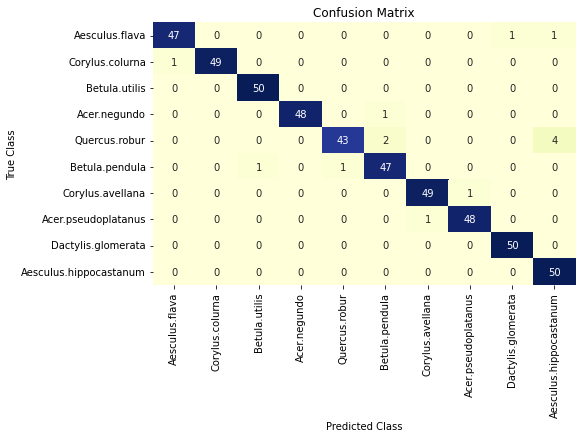

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.savefig('cm.png')
plt.show()